In [440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter


sns.set_theme()

# Exploratory Data analysis of ProPublica's Compas data

## Load data and recreate filters from ProPublica

In [441]:
# Load data and transform date columsn to "datetime"
raw_data = pd.read_csv("../../data-ProPublica/compas-scores-two-years.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape

(7214, 53)

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.*

In [442]:
# Select columns of interest and store as new df
df = raw_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(df["score_text"]!="N/A")
      ]

df.shape

(6172, 13)

In [443]:
#Change dtype for categorical features
category_cols = ['c_charge_degree', "race", "age_cat", 'score_text', 'sex', 'is_recid', 'two_year_recid']
df = df.apply(lambda s: s.astype('category') if s.name in category_cols else s)

## Demographic breakdown

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [444]:
df["length_of_stay_days"] = (df.c_jail_out-df.c_jail_in).dt.days
np.round(df[["length_of_stay_days", "decile_score"]].corr()\
    .loc["length_of_stay_days","decile_score"],5)

0.20748

After filtering we have the following demographic breakdown:

In [445]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [446]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

African-American    51.44%
Caucasian           34.07%
Hispanic             8.25%
Other                5.56%
Asian                0.50%
Native American      0.18%
Name: race, dtype: object

In [447]:
df.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [448]:
pd.crosstab(df["sex"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [449]:
df.sex.value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [450]:
(df.sex.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

Male      80.96%
Female    19.04%
Name: sex, dtype: object

In [451]:
no_recid = np.sum(df["two_year_recid"]==1)
print("Number of entries with two_year_recid:", no_recid)
print("% of entries with two_year_recid", np.round(no_recid/df.shape[0]*100,2))

Number of entries with two_year_recid: 2809
% of entries with two_year_recid 45.51


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

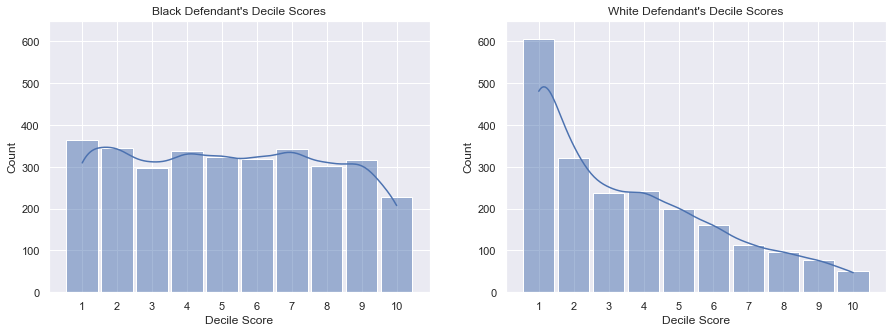

In [452]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");


In [453]:
pd.crosstab(df["decile_score"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.


In [454]:
#filter category columns
cols_cat = ['score_text','age_cat','sex','race','c_charge_degree']

#all columns of the subset
cols_df = ['score_text','sex','age_cat','race','priors_count','two_year_recid','c_charge_degree']

#define cat columns as category type
df.loc[:,cols_cat].astype('category')

#define data frame and do dummies coding for all cat columns
df_lr = pd.DataFrame(df, columns = cols_df)
df_lr = pd.get_dummies(data=df_lr,columns =cols_cat)

#bring Medium and High to 1 column
df_lr['score_text'] = df_lr['score_text_Medium'] + df_lr['score_text_High']

      
df = df_lr.rename(columns={"age_cat_Less than 25": "age_cat_Less_than_25", "age_cat_Greater than 45": "age_cat_Greater_than_45","race_Native American":"race_Native_American","race_African-American":"race_African_American"})    

formula = 'score_text ~ sex_Female + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + priors_count + c_charge_degree_M + two_year_recid'

score_mod = logit(formula, data = df).fit()
print(score_mod.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             score_text   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                  0.2729
Time:                        17:11:06   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.5255      0.079    -19.430      0.000      -1.679   

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [455]:
#calculating odds from the log ogss result above
control = np.exp(-1.5255) / (1 + np.exp(-1.5255))
#control is the probability of white man between 25-45 to receive a higher score

#calculation of blackman to receive a higher score
np.exp(0.4772) / (1 - control + (control * np.exp(0.4772)))


1.452825407001621

In [456]:
(np.exp(-1.5255+0.4772)+np.exp(0.4772)) / (1+np.exp(-1.5255+0.4772))

1.4528254070016209

Women are 19.4% more likely than men to get a higher score.

In [457]:
np.exp(0.22127) / (1 - control + (control * np.exp(0.22127)))

1.1947961876689026

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [458]:
np.exp(1.3084) / (1 - control + (control * np.exp(1.3084)))

2.496107351371129

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [459]:
# Load data and transform date columsn to "datetime"
raw_data = pd.read_csv("../../data-ProPublica/compas-scores-two-years-violent.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape[0] 

4743

In [460]:
# Select columns of interest and store as new df
df = raw_data[["age", "c_charge_degree", "race", "age_cat", "v_score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "v_decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(df["score_text"]!="N/A")
      ]

df.shape

(4020, 13)

In [461]:
df.age_cat.value_counts()

25 - 45            2300
Greater than 45     954
Less than 25        766
Name: age_cat, dtype: int64

In [462]:
df.race.value_counts()

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

In [463]:
df.v_score_text.value_counts()

Low       2913
Medium     828
High       279
Name: v_score_text, dtype: int64

In [464]:
#find % of row numbers with two year recid = 1
df[(df['two_year_recid'] ==1) ].shape[0] / df.shape[0]*100


16.218905472636816

In [465]:
#find row numbers with two year recid = 1
df[(df['two_year_recid'] ==1) ].shape[0]

652

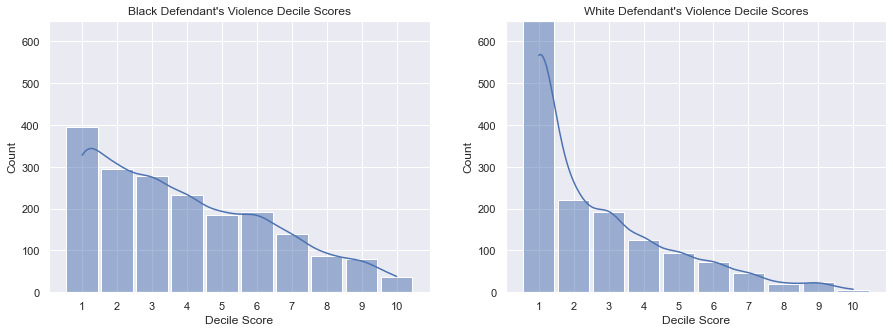

In [466]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["v_decile_score"]
scores_white = df[df["race"]=="Caucasian"]["v_decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Violence Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Violence Decile Scores");


In [467]:
#Logistic Regression of Violence Decile Score

#filter category columns
cols_cat = ['v_score_text','age_cat','sex','race','c_charge_degree']

#all columns of the subset
cols_df = ['v_score_text','sex','age_cat','race','priors_count','two_year_recid','c_charge_degree']

#define cat columns as category type
df.loc[:,cols_cat].astype('category')

#define data frame and do dummies coding for all cat columns
df_lr = pd.DataFrame(df, columns = cols_df)
df_lr = pd.get_dummies(data=df_lr,columns =cols_cat)

#bring Medium and High to 1 column
df_lr['v_score_text'] = df_lr['v_score_text_Medium'] + df_lr['v_score_text_High']

      
df = df_lr.rename(columns={"age_cat_Less than 25": "age_cat_Less_than_25", "age_cat_Greater than 45": "age_cat_Greater_than_45","race_Native American":"race_Native_American","race_African-American":"race_African_American"})    

formula = 'v_score_text ~ sex_Female + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + priors_count + c_charge_degree_M + two_year_recid'

score_mod = logit(formula, data = df).fit()
print(score_mod.summary())

Optimization terminated successfully.
         Current function value: 0.372983
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           v_score_text   No. Observations:                 4020
Model:                          Logit   Df Residuals:                     4008
Method:                           MLE   Df Model:                           11
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                  0.3662
Time:                        17:11:07   Log-Likelihood:                -1499.4
converged:                       True   LL-Null:                       -2365.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.2427      0.113    -19.802      0.000      -2.465   

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants. (between 25-45)

In [468]:
control = np.exp(-2.2427) / (1 + np.exp(-2.2427))
np.exp(0.6589) / (1 - control + (control * np.exp(0.6589 )))

1.7738715321327136

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [469]:
np.exp(3.1459) / (1 - control + (control * np.exp(3.1459)))

7.4140359085177545

## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [470]:
# Load data and transform date column to "datetime"
raw_data = pd.read_csv("../../data-ProPublica/cox-parsed.csv")
df_cp = raw_data.copy()

df_cp = df_cp[(df_cp["end"]>df_cp["start"])].dropna(subset=['score_text'])
df_cp_clean = df_cp.drop_duplicates(["id"])

df_cp_clean.shape
print(df_cp_clean.columns)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')


In [471]:
#renaming columns
df_cp_clean = df_cp_clean.rename(columns={"race": "race_factor", 'score_text': "score_factor"})

In [472]:
df_cp_clean.score_factor.value_counts()

Low       5751
Medium    2611
High      1952
Name: score_factor, dtype: int64

In [473]:
df_cp_clean.race_factor.value_counts()

African-American    5147
Caucasian           3569
Hispanic             944
Other                571
Asian                 51
Native American       32
Name: race_factor, dtype: int64

In [474]:
df_score = df_cp[['is_recid','start','end','score_text']]
df_score['duration'] = df_score['end']-df_score['start']
df_score=pd.get_dummies(df_score)



/var/folders/2f/n2m_d1sn0bx5nthf7csps2b40000gn/T/ipykernel_3486/2511150612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score['duration'] = df_score['end']-df_score['start']


In [475]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi


cph = CoxPHFitter()
df_score = df_score[['is_recid','duration','score_text_High','score_text_Medium']]
cph.fit(df_score, 'duration', 'is_recid')
cph.print_summary() 


<lifelines.CoxPHFitter: fitted with 13344 total observations, 9016 right-censored observations>
             duration col = 'duration'
                event col = 'is_recid'
      baseline estimation = breslow
   number of observations = 13344
number of events observed = 4328
   partial log-likelihood = -38768.74
         time fit was run = 2021-12-16 16:11:08 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
score_text_High     1.22       3.38       0.04             1.14             1.29                 3.14                 3.63
score_text_Medium   0.76       2.13       0.04             0.69             0.83                 1.98                 2.30

                      z      p   -log2(p)
covariate                                
score_text_High   32.72 <0.005     777.68
score_text_Medium 20.44 <0.005     306.15
---
Concordance = 0.63
Partial AIC = 77541.47
log-likelihood ratio test = 1101.79 on 2 df
-log2(p) of ll-ratio test = 794.77

People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [476]:
df_decile = df_cp[['is_recid','start','end','decile_score']]
df_decile['duration'] = df_decile['end']-df_decile['start']
#df_decile=pd.get_dummies(df_decile)
#print(df_decile)


/var/folders/2f/n2m_d1sn0bx5nthf7csps2b40000gn/T/ipykernel_3486/1585874853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_decile['duration'] = df_decile['end']-df_decile['start']


In [477]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi


cph = CoxPHFitter()
df_decile = df_decile[['is_recid','duration','decile_score']]
cph.fit(df_decile, 'duration', 'is_recid')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 13344 total observations, 9016 right-censored observations>
             duration col = 'duration'
                event col = 'is_recid'
      baseline estimation = breslow
   number of observations = 13344
number of events observed = 4328
   partial log-likelihood = -38672.30
         time fit was run = 2021-12-16 16:11:09 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
decile_score   0.19       1.21       0.01             0.18             0.20                 1.20                 1.22

                 z      p   -log2(p)
covariate                           
decile_score 36.02 <0.005     941.61
---
Concordance = 0.66
Partial AIC = 77346.61
log-likelihood ratio test = 1294.65 on 1 df
-log2(p) of ll-ratio test = 939.39

COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [478]:
df_score['score_text_High']=df_score['score_text_High']+1
print(df_score)

       is_recid  duration  score_text_High  score_text_Medium
0             0       327                1                  0
1             0       627                1                  0
2             1       150                1                  0
3             1        63                1                  0
4             1         1                1                  0
...         ...       ...              ...                ...
13414         0       450                1                  1
13415         0       808                1                  0
13416         0       754                1                  0
13417         1       258                1                  0
13418         1         1                1                  0

[13344 rows x 4 columns]


In [483]:
df_score['score_text'] = df_score['score_text_High']+df_score['score_text_Medium']
print(df_score)


       is_recid  duration  score_text_High  score_text_Medium  score_text
0             0       327                1                  0           1
1             0       627                1                  0           1
2             1       150                1                  0           1
3             1        63                1                  0           1
4             1         1                1                  0           1
...         ...       ...              ...                ...         ...
13414         0       450                1                  1           2
13415         0       808                1                  0           1
13416         0       754                1                  0           1
13417         1       258                1                  0           1
13418         1         1                1                  0           1

[13344 rows x 5 columns]


In [486]:
#cph.fit(df_score, 'duration', 'is_recid')
cph.plot_partial_effects_on_outcome(covariates='score_text', values=np.arange(1,3), cmap='coolwarm')

KeyError: 'covariate `score_text` is not present in the original dataset'

## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [ ]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("../../data-ProPublica/cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [ ]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [ ]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [ ]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [ ]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [ ]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

In [ ]:
44.85 / 23.45

1.9125799573560769

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [ ]:
47.72 / 27.99

1.7048946052161487

In [ ]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [ ]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [ ]:
vpeople = []
with open("../../data-ProPublica/cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [ ]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


Even moreso for Black defendants.

In [ ]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [ ]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [ ]:
38.14 / 18.46

2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [ ]:
62.62 / 38.37

1.63200416992442

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [ ]:
female = df_cp[df_cp["sex"]=="Female"]
male = df_cp[df_cp["sex"]=="Male"]